In [1]:
import numpy as np
import math
import pandas as pd
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.optim as optim
import torch.nn as nn
np.random.seed(0)

In [37]:
file_path = "/content/drive/MyDrive/Sunspots.csv"

# Load the data from the CSV file
time_step = []
sunspots = []

with open(file_path) as csvfile:
    reader = csv.reader(csvfile, delimiter=",")

    print("First few rows of the CSV file:")
    for i, row in enumerate(reader):
        if i == 0:
          continue
        if i < 5:
            print(row)
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

series = np.array(sunspots)
time = np.array(time_step)

def create_sequences(series, seq_length):
    xs, ys = [], []
    for i in range(len(series) - seq_length):
        x = series[i:i + seq_length]
        y = series[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 64
batch_size = 32

# Create sequences and labels
x_data, y_data = create_sequences(series, seq_length)

# Split data into training and test sets
split_ratio = 0.8
split_index = int(len(x_data) * split_ratio)

train_data = x_data[:split_index]
train_labels = y_data[:split_index]
test_data = x_data[split_index:]
test_labels = y_data[split_index:]

First few rows of the CSV file:
['0', '1749-01-31', '96.7']
['1', '1749-02-28', '104.3']
['2', '1749-03-31', '116.7']
['3', '1749-04-30', '92.8']


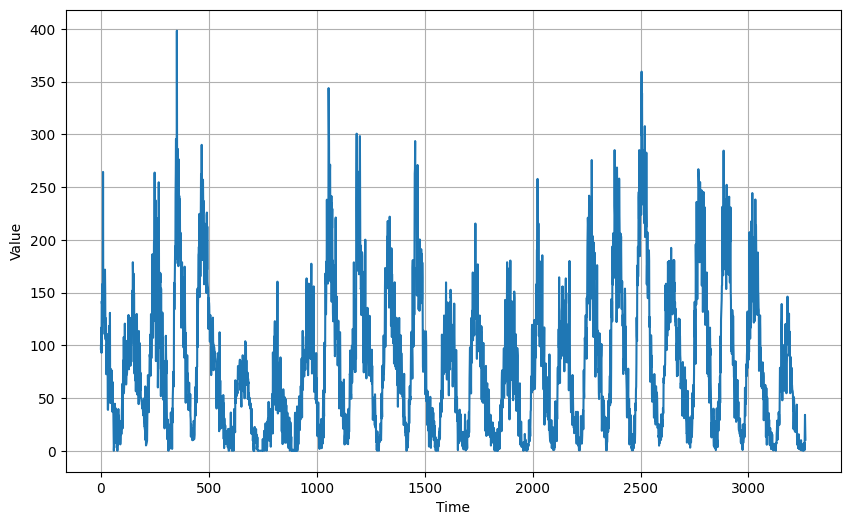

In [35]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [33]:
# Convert data to PyTorch tensors
train_data_tensor = torch.tensor(train_data[:, :, np.newaxis], dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels[:, np.newaxis], dtype=torch.float32)

input_size = 1
hidden_size = 64
output_size = 1
seq_length = 1
batch_size = 32
epochs = 300
lr = 1e-3

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.hidden_size = hidden_size

        i_weight_stddev = np.sqrt(2.0 / (input_size + hidden_size))
        self.i_weight = nn.Parameter(torch.randn(input_size, hidden_size) * i_weight_stddev)

        h_weight_stddev = np.sqrt(2.0 / (hidden_size + hidden_size))
        self.h_weight = nn.Parameter(torch.randn(hidden_size, hidden_size) * h_weight_stddev)

        self.h_bias = nn.Parameter(torch.zeros(1, hidden_size))

        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),  # Using ReLU activation for non-linearity
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        batch_size, seq_length, input_size = x.size()
        hidden = torch.zeros(1, batch_size, self.hidden_size)
        outputs, _ = self.rnn(x, hidden)
        outputs = self.fc(outputs)
        return outputs[:, -1, :]

# Create model instance
model = CustomRNN(input_size, hidden_size, output_size)

optimizer = optim.Adam(model.parameters(), lr=lr)

def mse_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0

    for batch_start in range(0, len(train_data) - seq_length, batch_size):
        batch_end = batch_start + batch_size
        seq_x = train_data_tensor[batch_start:batch_end]
        seq_y = train_labels_tensor[batch_start:batch_end]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(seq_x)

        # Calculate loss
        loss = mse_loss(seq_y, outputs)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    epoch_loss /= num_batches

    if epoch % 15 == 0:
        print(f"Epoch: {epoch} train loss {epoch_loss}")

Epoch: 0 train loss 9182.031682624816
Epoch: 15 train loss 665.6758877182007
Epoch: 30 train loss 662.6631859970092
Epoch: 45 train loss 650.6942311096192
Epoch: 60 train loss 639.3096251296997
Epoch: 75 train loss 633.7002050399781
Epoch: 90 train loss 627.2781414031982
Epoch: 105 train loss 625.4370777511597
Epoch: 120 train loss 618.5099498939514
Epoch: 135 train loss 614.5745450210571
Epoch: 150 train loss 606.2046872901916
Epoch: 165 train loss 623.8488029861451
Epoch: 180 train loss 601.707236213684
Epoch: 195 train loss 601.2640758514405
Epoch: 210 train loss 600.0018753242492
Epoch: 225 train loss 590.5552632522583
Epoch: 240 train loss 583.3509974288941
Epoch: 255 train loss 636.4045028877258
Epoch: 270 train loss 597.5680164909363
Epoch: 285 train loss 609.4684275627136


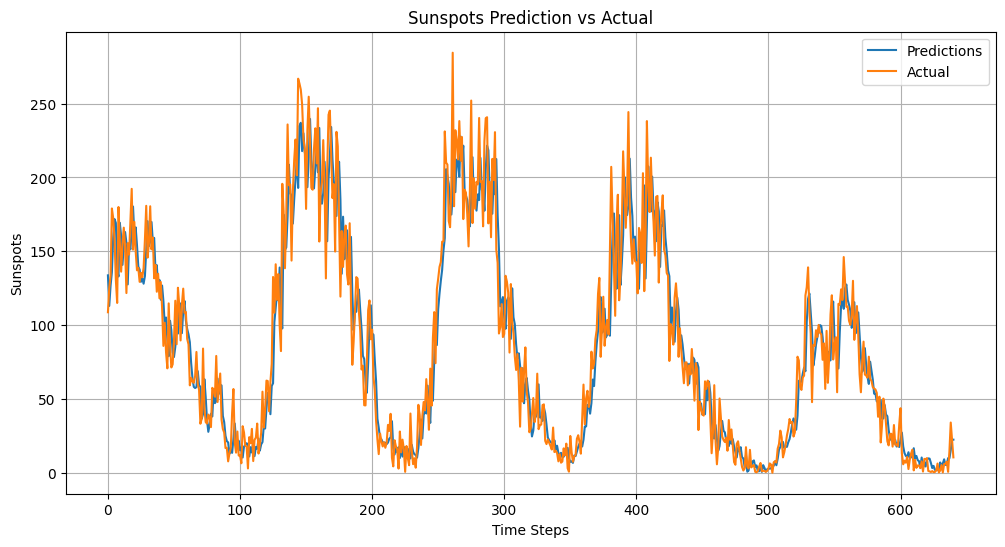

In [40]:
model.eval()

test_data_tensor = torch.tensor(test_data[:, :, np.newaxis], dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels[:, np.newaxis], dtype=torch.float32)

# Evaluate the model
with torch.no_grad():
    predictions = model(test_data_tensor)

# Convert predictions and labels to numpy arrays
predictions = predictions[:, -1].numpy()  # Assuming you want the last prediction of each sequence
test_labels = test_labels_tensor.numpy()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predictions')
plt.plot(test_labels, label='Actual')
plt.xlabel('Time Steps')
plt.ylabel('Sunspots')
plt.title('Sunspots Prediction vs Actual')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# def init_params(layer_conf):
#     layers = []
#     for i in range(1, len(layer_conf)):
#         np.random.seed(0)
#         k = 1/math.sqrt(layer_conf[i]["hidden"])
#         i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k

#         h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
#         h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

#         o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
#         o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

#         layers.append(
#             [i_weight, h_weight, h_bias, o_weight, o_bias]
#         )
#     return layers

In [ ]:
# def forward(x, layers):
#     hiddens = []
#     outputs = []
#     for i in range(len(layers)):
#         i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
#         hidden = np.zeros((x.shape[0], i_weight.shape[1]))
#         output = np.zeros((x.shape[0], o_weight.shape[1]))
#         for j in range(x.shape[0]):
#             input_x = x[j,:][np.newaxis,:] @ i_weight
#             hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
#             hidden_x = np.tanh(hidden_x)
#             hidden[j,:] = hidden_x
#             output_x = hidden_x @ o_weight + o_bias
#             output[j,:] = output_x
#         hiddens.append(hidden)
#         outputs.append(output)
#     return hiddens, outputs[-1]

In [ ]:
# def backward(layers, x, lr, grad, hiddens):
#     for i in range(len(layers)):
#         i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
#         hidden = hiddens[i]
#         next_h_grad = None
#         i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

#         for j in range(x.shape[0] - 1, -1, -1):
#             out_grad = grad[j,:][np.newaxis, :]
#             o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
#             o_bias_grad += out_grad
#             h_grad = out_grad @ o_weight.T

#             if j < x.shape[0] - 1:
#                 hh_grad = next_h_grad @ h_weight.T
#                 h_grad += hh_grad

#             tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2
#             h_grad = np.multiply(h_grad, tanh_deriv)

#             next_h_grad = h_grad.copy()

#             if j > 0:
#                 h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
#                 h_bias_grad += h_grad

#             i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

#         lr = lr / x.shape[0]
#         i_weight -= i_weight_grad * lr
#         h_weight -= h_weight_grad * lr
#         h_bias -= h_bias_grad.mean(axis=0) * lr
#         o_weight -= o_weight_grad * lr
#         o_bias -= o_bias_grad.mean(axis=0) * lr
#         layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]

#     return layers


In [ ]:
# epochs = 250
# lr = 1e-5

# layer_conf = [
#     {"type": "input", "units": 1},
#     {"type": "rnn", "hidden": 64, "output": 1}
# ]

# layers = init_params(layer_conf)
# split_index = int(0.8 * len(train_x))
# train_data = train_x[:split_index]
# train_labels = train_y[:split_index]
# valid_data = train_x[split_index:]
# valid_labels = train_y[split_index:]

# for epoch in range(epochs):
#     epoch_loss = 0
#     num_batches = 0

#     for batch_start in range(0, len(train_data) - window_size, batch_size):
#         batch_end = batch_start + batch_size
#         seq_x = train_data[batch_start:batch_end]
#         seq_y = train_labels[batch_start:batch_end]

#         hiddens, outputs = forward(seq_x, layers)
#         grad = mse_grad(seq_y, outputs)
#         layers = backward(layers, seq_x, lr, grad, hiddens)

#         epoch_loss += mse(seq_y, outputs)
#         num_batches += 1

#     epoch_loss /= num_batches

#     if epoch % 50 == 0:
#         valid_loss = 0
#         num_batches = 0

#         for batch_start in range(0, len(valid_data) - window_size, batch_size):
#             batch_end = batch_start + batch_size
#             seq_x = valid_data[batch_start:batch_end]
#             seq_y = valid_labels[batch_start:batch_end]

#             _, outputs = forward(seq_x, layers)
#             valid_loss += mse(seq_y, outputs)
#             num_batches += 1

#         valid_loss /= num_batches

#         print(f"Epoch: {epoch} train loss {epoch_loss} valid loss {valid_loss}")